# Music Classification Using PySpark

## Project Description
Music genre classification is a key area of music informatics that involves categorizing music into different genres based on its audio characteristics. With the aid of advanced machine learning technologies, even a short audio clip can be sufficient to retrieve relevant information. However, this process still faces significant challenges, particularly in handling the large-scale data and computational demands required for accurate classification. Traditional methods often struggle with memory management and handling large-scale datasets.

## Data And Methodology

In this project, we aim to build a distributed music genre classification system based on the Spark framework to achieve better load management and improved recognition performance. The data pipeline is described as follows: 

- Data Storage: HDFS
- Audio processing: Librosa, FFmpeg
- Data processing framework: Spark
- Visualization: Matplotlib, Spark UI

We would first establish an HDFS to store original audio files, from which the Spark would efficiently read data.

For the feature extraction, we would apply Librosa to get different features, which would be stored as Parquet format in Sqlite for further usage.

## Step 1: Set Up Distributed Storage and Spark Environment

### Establish HDFS Cluster 

#### Install Java
First check the Java version:

```bash 
java -version
```

If Java is not installed, you can install OpenJDK:

```bash
sudo apt install openjdk-11-jdk
```

#### Download Hadoop

```bash
wget https://dlcdn.apache.org/hadoop/common/hadoop-3.3.6/hadoop-3.3.6.tar.gz
```

####  Extract Hadoop

```bash
tar -xzf hadoop-3.3.6.tar.gz
mv hadoop-3.3.6 /usr/local/hadoop
```
#### Set Hadoop Environment Variables
Open .bashrc file:
```bash
vi ~/.bashrc
```
Add the following lines to set up Hadoop and Java paths:
```bash
export HADOOP_HOME=/usr/local/hadoop
export PATH=$PATH:$HADOOP_HOME/bin
export JAVA_HOME=$(readlink -f /usr/bin/java | sed "s:/bin/java::")
```
Add the following line to include the sbin directory in the PATH:
```bash
export HADOOP_HOME=/usr/local/hadoop
export PATH=$PATH:$HADOOP_HOME/bin:$HADOOP_HOME/sbin
```
Save and reload .bashrc:
```bash
source ~/.bashrc
```
#### Configure Hadoop Files
Configure core-site.xml to set the default filesystem:
```bash
vi $HADOOP_HOME/etc/hadoop/core-site.xml
```

Add the following configuration inside the <configuration> tags:
```bash
<configuration>
    <property>
       <name>fs.defaultFS</name>
       <value>hdfs://localhost:9000</value>
    </property>
</configuration>
```
Set up replication and directory paths for Namenode and Datanode in hdfs-site.xml:
```bash
vi $HADOOP_HOME/etc/hadoop/hdfs-site.xml
```
Add the following inside the <configuration> tags:
```bash
<configuration>
    <property>
        <name>dfs.replication</name>
        <value>1</value>
    </property>
    <property>
        <name>dfs.namenode.name.dir</name>
        <value>file:///usr/local/hadoop/hdfs/namenode</value>
    </property>
    <property>
        <name>dfs.datanode.data.dir</name>
        <value>file:///usr/local/hadoop/hdfs/datanode</value>
    </property>
</configuration>

```
#### Format the Namenode
```bash
hdfs namenode -format
```
#### Create a New User for Hadoop Services
```bash
sudo adduser hadoop
```
After creating the user, switch to the hadoop user:
```bash
su - hadoop
```
Set permissions for the Hadoop directory:
```bash
sudo chown -R hadoop:hadoop /usr/local/hadoop
```
#### Configure Environment Variables for the New User
Open .bashrc:
```bash
vi ~/.bashrc
```
Add the following lines:
```bash
export HADOOP_HOME=/usr/local/hadoop
export PATH=$PATH:$HADOOP_HOME/bin:$HADOOP_HOME/sbin
export JAVA_HOME=$(readlink -f /usr/bin/java | sed "s:/bin/java::")
```
Save the file and reload:
```bash
source ~/.bashrc
```
#### Set HDFS User Variables in hadoop-env.sh
```bash
vi $HADOOP_HOME/etc/hadoop/hadoop-env.sh
```
Add these lines (if they don’t exist) to define the user for HDFS services:
```bash
export HDFS_NAMENODE_USER=hadoop
export HDFS_DATANODE_USER=hadoop
export HDFS_SECONDARYNAMENODE_USER=hadoop
```
#### Generate an SSH Key Pair (as hadoop user)
```bash
ssh-keygen -t rsa -P "" -f ~/.ssh/id_rsa
```
Add the public key to authorized_keys:
```bash
cat ~/.ssh/id_rsa.pub >> ~/.ssh/authorized_keys
```
Ensure the file permissions are correct:
```bash
chmod 700 ~/.ssh
chmod 600 ~/.ssh/authorized_keys
```
Test SSH access to localhost:
```bash
ssh localhost
```
#### Verify OpenJDK Path
```bash
readlink -f /usr/bin/java | sed "s:/bin/java::"
```
#### Set JAVA_HOME in Hadoop Environment Configuration
Open the Hadoop environment configuration file:
```bash
vi /usr/local/hadoop/etc/hadoop/hadoop-env.sh
```
Set JAVA_HOME with the path found:
```bash
export JAVA_HOME=/usr/lib/jvm/java-11-openjdk-amd64
```
#### Start Hadoop Services
```bash
start-dfs.sh
```
#### Upload Dataset to HDFS
Create a directory and upload the dataset:
```bash
hdfs dfs -mkdir -p /user/hadoop/Music/Dataset
hdfs dfs -put /home/hadoop/Dataset/* /user/hadoop/Music/Dataset/
```
Verify if the dataset has been successfully uploaded:
```bash
hdfs dfs -ls /user/hadoop/Music/Dataset
```

### Spark Configuration

Next, we set up a Spark cluster, configuring it to read directly from HDFS (or the chosen storage solution) and handle distributed data processing. We have installed Java-8, and the spark-3.5.3-bin-hadoop3 files are placed under current project folder.

In [3]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "./spark-3.5.3-bin-hadoop3"

In [20]:
# If a SparkSession already exists, stop it
if 'spark' in locals():
    spark.stop()

# If a SparkContext already exists, stop it
if 'sc' in locals():
    sc.stop()

In [21]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf

ui_port = 4040
conf = SparkConf() \
    .setAppName("Music_Classification") \
    .set("spark.ui.port", str(ui_port)) \
    .set("spark.executor.memory", "2g") \
    .set("spark.executor.cores", "4") \
    .set("spark.executor.instances", "8") \
    .set("spark.driver.memory", "10g") \
    .set("spark.driver.cores", "4")                 

sc = SparkContext(conf=conf)
spark = SparkSession.builder.appName("Music_Classification").getOrCreate()
spark

# import pyspark
# from pyspark.sql import SparkSession
# spark = SparkSession.builder.appName("Music_Classification").getOrCreate()

# cores = spark._jsc.sc().getExecutorMemoryStatus().keySet().size()
# print("You are working with", cores, "core(s)")
# spark

For visualization

## Step 2: Feature Extraction from Audio Files

### Extract Features with Librosa

In [24]:
genres = ["classical", "jazz", "rock","country","disco","hiphop","jazz","metal","pop","reggae"]  # 假设这些是文件夹名称
hdfs_path = "hdfs://localhost:9000/user/hadoop/Music/Dataset/Data/genres_original/"
# Place to store DataFrames
dataframes = {}

for genre in genres:
    # Construct the path
    folder_path = f"{hdfs_path}{genre}/*.wav"
    try:
        # Read .wav files
        df = spark.read.format("binaryFile").load(folder_path)
        dataframes[genre] = df  # Store DataFrame with folder name as the key
    except Exception as e:
        print(f"Error loading {folder_path}: {e}")

In [ ]:
! pip install librosa

Function for features extraction from content

In [25]:
import numpy as np
import librosa
from pyspark.sql.functions import pandas_udf
from pyspark.sql.types import ArrayType, FloatType

# Feature extraction function
def extract_features_from_content(content):
    audio_data = np.frombuffer(content, dtype=np.float32)
    
    # Normalize the data for librosa processing
    y = librosa.util.buf_to_float(audio_data, dtype=np.float32)
    sr = 22050  # Assign a fixed sample rate

    
    # Extract features
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfcc_mean = np.mean(mfcc, axis=1)
    mfcc_std = np.std(mfcc, axis=1)
    
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma_mean = np.mean(chroma, axis=1)
    chroma_std = np.std(chroma, axis=1)
    
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    spectral_centroid_mean = np.mean(spectral_centroid)
    spectral_centroid_std = np.std(spectral_centroid)
    
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    spectral_contrast_mean = np.mean(spectral_contrast, axis=1)
    spectral_contrast_std = np.std(spectral_contrast, axis=1)
    
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y)
    zero_crossing_rate_mean = np.mean(zero_crossing_rate)
    zero_crossing_rate_std = np.std(zero_crossing_rate)
    
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    spectral_rolloff_mean = np.mean(spectral_rolloff)
    spectral_rolloff_std = np.std(spectral_rolloff)
    
    # Combine all features into one array
    features = np.hstack([
        mfcc_mean, mfcc_std,
        chroma_mean, chroma_std,
        [spectral_centroid_mean, spectral_centroid_std],
        spectral_contrast_mean, spectral_contrast_std,
        [zero_crossing_rate_mean, zero_crossing_rate_std],
        [spectral_rolloff_mean, spectral_rolloff_std]
    ])
    
    return features.tolist()

# Define UDF to apply the feature extraction function to each row
@pandas_udf(ArrayType(FloatType()))
def extract_audio_features(content):
    return content.apply(extract_features_from_content)


In [26]:
from pyspark.sql.functions import lit
from pyspark.sql.functions import regexp_extract
#extract
for genre, df in dataframes.items():
    dataframes[genre] = df.withColumn("audio_features", extract_audio_features("content"))
    
#add label
for genre, df in dataframes.items():    
    dataframes[genre] = df.withColumn("label", lit(genre))


#add id
for genre, df in dataframes.items():
    # Extract the filename part using regex and store it in a new column 'id'
    df = df.withColumn("id", regexp_extract("path", r"[^/]+$", 0))
    dataframes[genre] = df

In [27]:
dataframes["hiphop"].columns


['path',
 'modificationTime',
 'length',
 'content',
 'audio_features',
 'label',
 'id']

### Store Features as Parquet in HDFS

After extracting features, we store them in Parquet format directly in HDFS. Storing extracted features as Parquet in HDFS is beneficial for large-scale, distributed machine learning workflows. We consider to save these features mainly because the following benefits:

- **Reusable Preprocessed Data**: Instead of re-extracting features every time we run or test different models, we can quickly load the Parquet file, saving time and resources. This is especially useful for experimentation, hyperparameter tuning, or comparing multiple models.
- **Enabling Scalability for Large Datasets**: If we want to scale up our model(continuously adding more training data), eventually the features will be come a large dataset. Parquet is a columnar storage format that allows for efficient compression and encoding of data. This reduces storage costs and the amount of disk I/O required, which is valuable when working with large feature datasets. 

In [28]:
spark.catalog.clearCache()

In [30]:
# Save each genre DataFrame to HDFS
feature_path="hdfs://localhost:9000/user/hadoop/Music/Dataset/Features/"
# Save only the required columns for each genre
for genre, df in dataframes.items():
    # Select only the 'audio_features' and 'label' columns
    processed_df = df.select("audio_features", "label")
    
    # Define the path for each genre's processed features
    genre_feature_path = f"{feature_path}{genre}/"
    
    # Write the DataFrame to HDFS in Parquet format
    processed_df.write.mode("overwrite").parquet(genre_feature_path)

24/10/27 17:24:50 WARN MemoryManager: Total allocation exceeds 95.00% (987,181,863 bytes) of heap memory
Scaling row group sizes to 91.94% for 8 writers
24/10/27 17:24:50 WARN MemoryManager: Total allocation exceeds 95.00% (987,181,863 bytes) of heap memory
Scaling row group sizes to 91.94% for 8 writers
24/10/27 17:24:50 WARN MemoryManager: Total allocation exceeds 95.00% (987,181,863 bytes) of heap memory
Scaling row group sizes to 81.72% for 9 writers
24/10/27 17:24:50 WARN MemoryManager: Total allocation exceeds 95.00% (987,181,863 bytes) of heap memory
Scaling row group sizes to 73.55% for 10 writers
24/10/27 17:24:50 WARN MemoryManager: Total allocation exceeds 95.00% (987,181,863 bytes) of heap memory
Scaling row group sizes to 66.86% for 11 writers
24/10/27 17:24:50 WARN MemoryManager: Total allocation exceeds 95.00% (987,181,863 bytes) of heap memory
Scaling row group sizes to 61.29% for 12 writers
24/10/27 17:24:50 WARN MemoryManager: Total allocation exceeds 95.00% (987,181,

## Step 3: Data Preprocessing and Transformation

### Load Parquet Data into Spark
We load the Parquet files from HDFS into Spark as DataFrames for efficient distributed processing.

In [31]:
processed_dataframes = {}

# Load each genre DataFrame from HDFS
for genre in dataframes.keys():
    genre_feature_path = f"{feature_path}{genre}/"
    
    # Read the Parquet file into a Spark DataFrame
    loaded_df = spark.read.parquet(genre_feature_path)
    
    # Add the loaded DataFrame to the dictionary
    processed_dataframes[genre] = loaded_df

### Preprocess Features

Perform any necessary data cleaning, normalization, or transformation directly within Spark using the DataFrame API to prepare the data for machine learning.

#### Merge all categories into one df

In [32]:
from functools import reduce
from pyspark.sql import DataFrame

all_data = reduce(DataFrame.unionAll, processed_dataframes.values())


#### remove unrelated data for training

In [33]:
columns_to_drop = ['path', 'modificationTime', 'content']
all_data = all_data.drop(*columns_to_drop)

# Displaying the remaining columns to confirm
all_data.columns

['audio_features', 'label']

#### Vectorization for sparkML

In [34]:
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, FloatType
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml import Pipeline

# Define a UDF to convert array<float> to DenseVector
array_to_vector_udf = udf(lambda arr: Vectors.dense(arr), VectorUDT())

# Convert the 'audio_features' column to Vector
all_data = all_data.withColumn("audio_features_vector", array_to_vector_udf("audio_features"))

# Use VectorAssembler to transform 'audio_features_vector' into 'features'
assembler = VectorAssembler(inputCols=["audio_features_vector"], outputCol="features")

# Index encode the 'label' column
indexer = StringIndexer(inputCol="label", outputCol="label_index")

# Create a Pipeline combining assembler and indexer
pipeline = Pipeline(stages=[assembler, indexer])

# Run the Pipeline and transform the data
prepared_data = pipeline.fit(all_data).transform(all_data)

# Check the transformed data columns
prepared_data.select("features", "label_index").columns

['features', 'label_index']

In [53]:
indexer_model = indexer.fit(all_data)

# Get the list of labels
labels = indexer_model.labels

# Create a mapping dictionary from index to label
index_to_label = {i: label for i, label in enumerate(labels)}

# Print the mapping
print(index_to_label)

{0: 'classical', 1: 'country', 2: 'disco', 3: 'hiphop', 4: 'jazz', 5: 'metal', 6: 'pop', 7: 'reggae', 8: 'rock'}


#### shuffle and drop

In [35]:
from pyspark.sql.functions import col
shuffle_seed = 1007
columns_drop = [ 'audio_features', 'audio_features_vector',]
final_data = prepared_data.drop(*columns_drop)
final_data = final_data.withColumn("label_index", col("label_index").cast("int"))
final_data.cache() 
train_data, val_data, test_data = final_data.randomSplit([0.8, 0.1, 0.1], seed=shuffle_seed)

In [36]:
train_data.printSchema()

root
 |-- label: string (nullable = true)
 |-- features: vector (nullable = true)
 |-- label_index: integer (nullable = true)



## Step 4: Model Selection and Training

### Choose an Appropriate ML Algorithm

In [37]:
## test all models
from pyspark.ml.classification import (
    LogisticRegression, OneVsRest, LinearSVC,
    RandomForestClassifier, GBTClassifier, DecisionTreeClassifier
)
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
def evaluate_models(train_data, val_data, test_data):

    models = {
               #error #
        "OneVsRest_SVC": OneVsRest(classifier=LinearSVC(featuresCol="features", labelCol="label_index", maxIter=10),labelCol="label_index",featuresCol="features",),
        "OneVsRest_GBT": OneVsRest(classifier=GBTClassifier(featuresCol="features", labelCol="label_index", maxIter=10),labelCol="label_index",featuresCol="features",),
        "LogisticRegression": LogisticRegression(featuresCol="features", labelCol="label_index", maxIter=10),
      #not for multi  #"LinearSVC": LinearSVC(featuresCol="features", labelCol="label_index", maxIter=10),
        "RandomForestClassifier": RandomForestClassifier(featuresCol="features", labelCol="label_index", numTrees=20),
        #not for multi"GBTClassifier": GBTClassifier(featuresCol="features", labelCol="label_index", maxIter=10),
        "DecisionTreeClassifier": DecisionTreeClassifier(featuresCol="features", labelCol="label_index")
    }
    
    # Evaluator
    evaluator = MulticlassClassificationEvaluator(labelCol="label_index", predictionCol="prediction", metricName="accuracy")
    
    # Store results
    results = {}

    trained_models = {}

    # Go through each model
    for model_name, model in models.items():
        print(f"Training {model_name}...")
        
        # Train the model
        trained_model = model.fit(train_data)
        
        # Evaluate accuracy on the validation set
        val_predictions = trained_model.transform(val_data)
        val_accuracy = evaluator.evaluate(val_predictions)
        
        # Evaluate accuracy on the test set
        test_predictions = trained_model.transform(test_data)
        test_accuracy = evaluator.evaluate(test_predictions)
        f1_score = evaluator.evaluate(val_predictions, {evaluator.metricName: "f1"})
        
        # Record results
        results[model_name] = {
            "Validation Accuracy": val_accuracy,
            "Test Accuracy": test_accuracy,
            "f1_score": f1_score
        }
        trained_models[model_name] = trained_model
        # Evaluate the model
        
        print(f"{model_name} - Validation Accuracy: {val_accuracy}, Test Accuracy: {test_accuracy}")
    
    return results,trained_models

### Train the Classifier on Spark

In [38]:
results,models = evaluate_models(train_data, val_data, test_data)
print("Model Performance Summary:", results)

Training OneVsRest_SVC...


OneVsRest_SVC - Validation Accuracy: 0.7727272727272727, Test Accuracy: 0.6774193548387096
Training OneVsRest_GBT...


OneVsRest_GBT - Validation Accuracy: 0.6477272727272727, Test Accuracy: 0.6236559139784946
Training LogisticRegression...
LogisticRegression - Validation Accuracy: 0.7613636363636364, Test Accuracy: 0.6989247311827957
Training RandomForestClassifier...


RandomForestClassifier - Validation Accuracy: 0.6477272727272727, Test Accuracy: 0.5698924731182796
Training DecisionTreeClassifier...


DecisionTreeClassifier - Validation Accuracy: 0.5, Test Accuracy: 0.43010752688172044
Model Performance Summary: {'OneVsRest_SVC': {'Validation Accuracy': 0.7727272727272727, 'Test Accuracy': 0.6774193548387096, 'f1_score': 0.7685899149869737}, 'OneVsRest_GBT': {'Validation Accuracy': 0.6477272727272727, 'Test Accuracy': 0.6236559139784946, 'f1_score': 0.6543332107067286}, 'LogisticRegression': {'Validation Accuracy': 0.7613636363636364, 'Test Accuracy': 0.6989247311827957, 'f1_score': 0.7629643841007477}, 'RandomForestClassifier': {'Validation Accuracy': 0.6477272727272727, 'Test Accuracy': 0.5698924731182796, 'f1_score': 0.6360227092394031}, 'DecisionTreeClassifier': {'Validation Accuracy': 0.5, 'Test Accuracy': 0.43010752688172044, 'f1_score': 0.47260851854153285}}


### Save Model to HDFS

In [39]:
for i, model_pack in enumerate(models.items()):
    model_name, model = model_pack
    save_path = f"hdfs://localhost:9000/user/hadoop/Music/Models/{model_name}_{i}"
    
    # Save the model
    model.save(save_path)
    print(f"Model {model_name} saved to {save_path}")

Py4JJavaError: An error occurred while calling o8621.save.
: java.io.IOException: Path hdfs://localhost:9000/user/hadoop/Music/Models/OneVsRest_SVC_0 already exists. To overwrite it, please use write.overwrite().save(path) for Scala and use write().overwrite().save(path) for Java and Python.
	at org.apache.spark.ml.util.FileSystemOverwrite.handleOverwrite(ReadWrite.scala:683)
	at org.apache.spark.ml.util.MLWriter.save(ReadWrite.scala:167)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:750)


If we want to load the models later, we can use the following command.

```python
from pyspark.ml.classification import LogisticRegressionModel, RandomForestClassificationModel

# Load Logistic Regression Model
lr_model_path = "hdfs://localhost:9000/user/hadoop/Music/Models/LogisticRegression_0"
loaded_lr_model = LogisticRegressionModel.load(lr_model_path)

# Load Random Forest Model
rf_model_path = "hdfs://localhost:9000/user/hadoop/Music/Models/RandomForestClassifier_1"
loaded_rf_model = RandomForestClassificationModel.load(rf_model_path)
```

## Step 5: Model Evaluation and Performance Monitoring

In [40]:
def ClassDiag(classifier):
    
    # Fit our model
    
    fitModel = classifier

    # Load the Summary
    trainingSummary = fitModel.summary

    # General Describe
    trainingSummary.predictions.describe().show()

    # View Predictions
    pred_and_labels = fitModel.evaluate(test_data)
    pred_and_labels.predictions.show()

    # Obtain the objective per iteration
    objectiveHistory = trainingSummary.objectiveHistory
    print(" ")
    print("objectiveHistory:")
    for objective in objectiveHistory:
        print(objective)

    # for multiclass, we can inspect metrics on a per-label basis
    print(" ")
    print("False positive rate by label:")
    for i, rate in enumerate(trainingSummary.falsePositiveRateByLabel):
        print("label %d: %s" % (i, rate))

    print(" ")
    print("True positive rate by label:")
    for i, rate in enumerate(trainingSummary.truePositiveRateByLabel):
        print("label %d: %s" % (i, rate))

    print(" ")
    print("Precision by label:")
    for i, prec in enumerate(trainingSummary.precisionByLabel):
        print("label %d: %s" % (i, prec))

    print(" ")
    print("Recall by label:")
    for i, rec in enumerate(trainingSummary.recallByLabel):
        print("label %d: %s" % (i, rec))

    print(" ")
    print("F-measure by label:")
    for i, f in enumerate(trainingSummary.fMeasureByLabel()):
        print("label %d: %s" % (i, f))

    accuracy = trainingSummary.accuracy
    falsePositiveRate = trainingSummary.weightedFalsePositiveRate
    truePositiveRate = trainingSummary.weightedTruePositiveRate
    fMeasure = trainingSummary.weightedFMeasure()
    precision = trainingSummary.weightedPrecision
    recall = trainingSummary.weightedRecall
    print(" ")
    print("Accuracy: %s\nFPR: %s\nTPR: %s\nF-measure: %s\nPrecision: %s\nRecall: %s"
          % (accuracy, falsePositiveRate, truePositiveRate, fMeasure, precision, recall)) 

In [41]:
ClassDiag(models['LogisticRegression'])

+-------+---------+------------------+------------------+
|summary|    label|       label_index|        prediction|
+-------+---------+------------------+------------------+
|  count|      719|               719|               719|
|   mean|     NULL|4.0305980528511824| 3.976356050069541|
| stddev|     NULL| 2.586478349928337|2.5803516346204742|
|    min|classical|               0.0|               0.0|
|    max|     rock|               8.0|               8.0|
+-------+---------+------------------+------------------+

+---------+--------------------+-----------+--------------------+--------------------+----------+
|    label|            features|label_index|       rawPrediction|         probability|prediction|
+---------+--------------------+-----------+--------------------+--------------------+----------+
|classical|[-123.89199829101...|          0|[7.74572545215266...|[0.87579153435564...|       0.0|
|classical|[-319.02673339843...|          0|[17.0289792762402...|[0.99999644847517...

### Visualization of Evaluation Metrics

## Step 6: Visualize and Report Results

### Generate Visualizations

In [42]:
for model_name, metrics in results.items():
    print(f"{model_name} - Accuracy: {metrics['Test Accuracy']:.3f}, F1-Score: {metrics['f1_score']:.3f}")

OneVsRest_SVC - Accuracy: 0.677, F1-Score: 0.769
OneVsRest_GBT - Accuracy: 0.624, F1-Score: 0.654
LogisticRegression - Accuracy: 0.699, F1-Score: 0.763
RandomForestClassifier - Accuracy: 0.570, F1-Score: 0.636
DecisionTreeClassifier - Accuracy: 0.430, F1-Score: 0.473


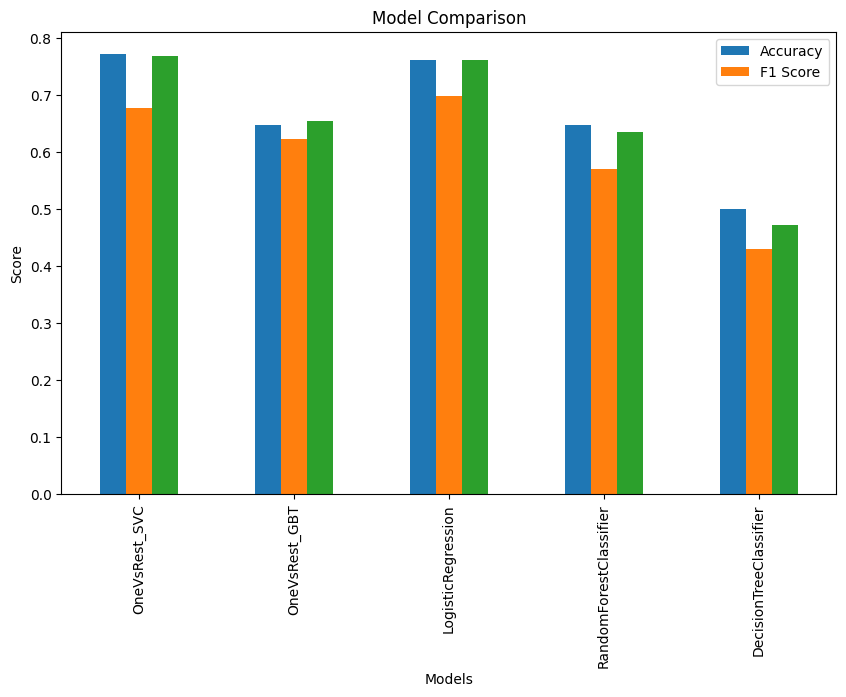

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert results dictionary to a DataFrame
metrics_df = pd.DataFrame(results).T

# Plot accuracy and F1-score for each model
metrics_df.plot(kind='bar', figsize=(10, 6))
plt.title("Model Comparison")
plt.xlabel("Models")
plt.ylabel("Score")
plt.legend(["Accuracy", "F1 Score"])
plt.show()


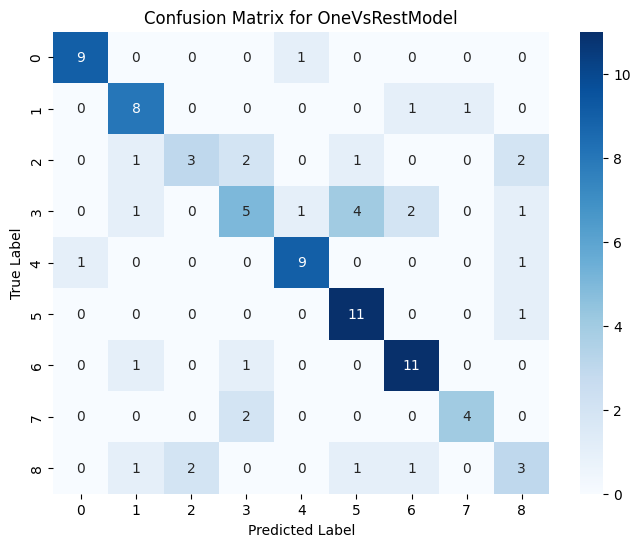

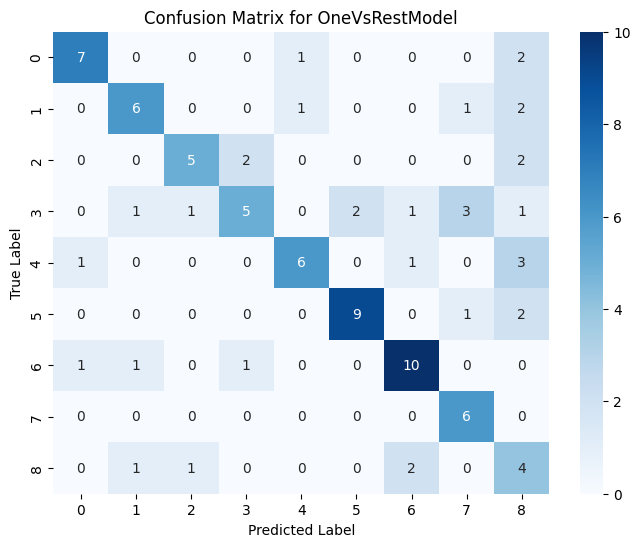

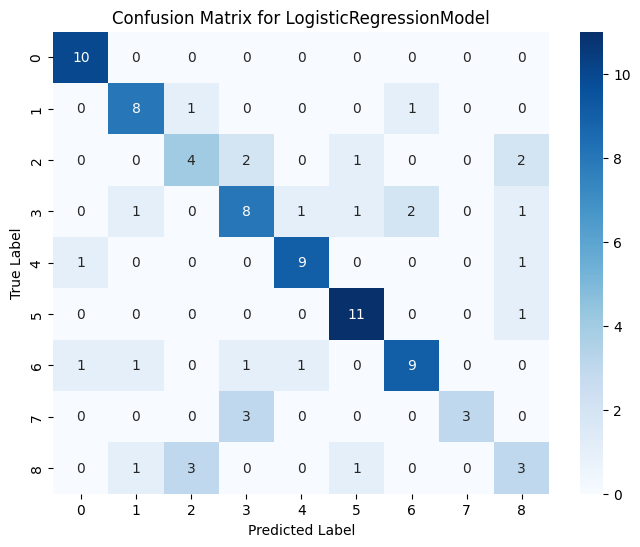

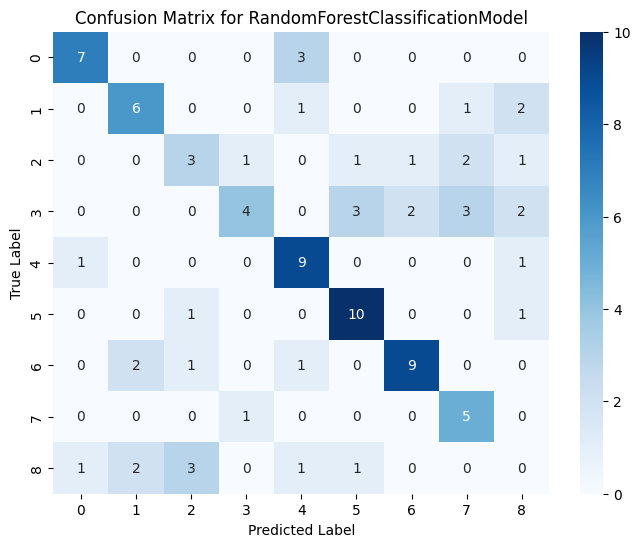

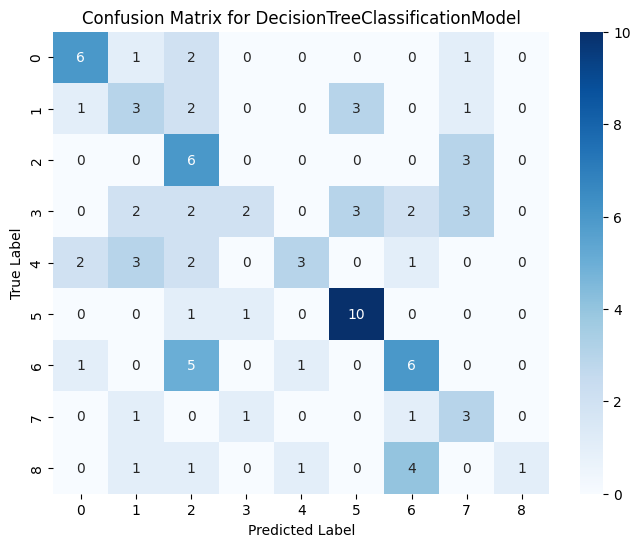

In [44]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

for model_name, model in models.items():
    # Make predictions and convert to Pandas
    model_name = model.__class__.__name__
    
    # Make predictions
    predictions = model.transform(test_data)
    pred_df = predictions.select("label_index", "prediction").toPandas()
    
    # Create confusion matrix
    cm = confusion_matrix(pred_df["label_index"], pred_df["prediction"])
    
    # Plot using Seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()


### Monitor System Performance with Spark UI

We use ngrok to monitor spark performance. A preset url is https://b154-58-144-141-209.ngrok-free.app

In [ ]:
from pyngrok import ngrok, conf
import getpass

print("Enter your authtoken, which can be copied "
"from https://dashboard.ngrok.com/get-started/your-authtoken")
conf.get_default().auth_token = getpass.getpass()

public_url = ngrok.connect(ui_port).public_url
print(f" * ngrok tunnel \"{public_url}\" -> \"http://127.0.0.1:{ui_port}\"")